# Scalable Additive-Structure GP Classification (CUDA) (w/ KISS-GP)

## Introduction

This example shows how to use a `AdditiveGridInducingVariationalGP` module. This classifcation module is designed for when the function you’re modeling has an additive decomposition over dimension. This is equivalent to using a covariance function that additively decomposes over dimensions:

$$k(\mathbf{x},\mathbf{x'}) = \sum_{i=1}^{d}k([\mathbf{x}]_{i}, [\mathbf{x'}]_{i})$$

where $[\mathbf{x}]_{i}$ denotes the ith component of the vector $\mathbf{x}$. Example applications of this include use in Bayesian optimization, and when performing deep kernel learning. 

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic in the number of data points.


In this example, we’re performing classification on a two dimensional toy dataset that is:
- Defined in [-1, 1]x[-1, 1]
- Valued 1 in [-0.5, 0.5]x[-0.5, 0.5]
- Valued -1 otherwise

The above function doesn't have an obvious additive decomposition, but it turns out that this function is can be very well approximated by the kernel anyways.

In [1]:
# High-level imports
import math
from math import exp
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make inline plots
%matplotlib inline

/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.7/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/gpleiss/.dotfiles/matplotlib/matplotlibrc", line #57
  (fname, cnt))


## Generate toy dataset

In [2]:
n = 101
train_x = torch.zeros(n ** 2, 2)
train_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
train_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
train_y = (train_x[:, 0].abs().lt(0.5)).float() * (train_x[:, 1].abs().lt(0.5)).float() * 2 - 1

train_x = train_x.cuda()
train_y = train_y.cuda()

## Define the model

In contrast to the most basic classification models, this model uses an `AdditiveGridInterpolationVariationalStrategy`. This causes two key changes in the model. First, the model now specifically assumes that the input to `forward`, `x`, is to be additive decomposed. Thus, although the model below defines an `RBFKernel` as the covariance function, because we extend this base class, the additive decomposition discussed above will be imposed. 

Second, this model automatically assumes we will be using scalable kernel interpolation (SKI) for each dimension. Because of the additive decomposition, we only provide one set of grid bounds to the base class constructor, as the same grid will be used for all dimensions. It is recommended that you scale your training and test data appropriately.

In [3]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import AdditiveGridInterpolationVariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import BernoulliLikelihood
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal

class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, grid_size=128, grid_bounds=([-1, 1],)):
        variational_distribution = CholeskyVariationalDistribution(num_inducing_points=grid_size, batch_size=2)
        variational_strategy = AdditiveGridInterpolationVariationalStrategy(self,
                                                                            grid_size=grid_size,
                                                                            grid_bounds=grid_bounds,
                                                                            num_dim=2,
                                                                            variational_distribution=variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=1))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = MultivariateNormal(mean_x, covar_x)
        return latent_pred

# Cuda the model and likelihood function
model = GPClassificationModel().cuda()
likelihood = gpytorch.likelihoods.BernoulliLikelihood().cuda()

## Training the model

Once the model has been defined, the training loop looks very similar to other variational models we've seen in the past. We will optimize the variational lower bound as our objective function. In this case, although variational inference in GPyTorch supports stochastic gradient descent, we choose to do batch optimization due to the relatively small toy dataset.

For an example of using the `AdditiveGridInducingVariationalGP` model with stochastic gradient descent, see the `dkl_mnist` example.

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.numel())

# Training function
def train(num_iter=200):
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
        optimizer.step()

%time train()

Iter 1/200 - Loss: 1.421
Iter 2/200 - Loss: 1.415
Iter 3/200 - Loss: 0.863
Iter 4/200 - Loss: 0.908
Iter 5/200 - Loss: 1.154
Iter 6/200 - Loss: 1.289
Iter 7/200 - Loss: 1.069
Iter 8/200 - Loss: 1.341
Iter 9/200 - Loss: 1.304
Iter 10/200 - Loss: 1.014
Iter 11/200 - Loss: 1.087
Iter 12/200 - Loss: 1.293
Iter 13/200 - Loss: 1.176
Iter 14/200 - Loss: 1.166
Iter 15/200 - Loss: 1.245
Iter 16/200 - Loss: 1.250
Iter 17/200 - Loss: 1.023
Iter 18/200 - Loss: 0.926
Iter 19/200 - Loss: 1.113
Iter 20/200 - Loss: 1.115
Iter 21/200 - Loss: 0.861
Iter 22/200 - Loss: 0.720
Iter 23/200 - Loss: 0.677
Iter 24/200 - Loss: 0.827
Iter 25/200 - Loss: 0.709
Iter 26/200 - Loss: 0.697
Iter 27/200 - Loss: 0.928
Iter 28/200 - Loss: 0.917
Iter 29/200 - Loss: 0.968
Iter 30/200 - Loss: 1.099
Iter 31/200 - Loss: 1.112
Iter 32/200 - Loss: 0.924
Iter 33/200 - Loss: 0.622
Iter 34/200 - Loss: 0.760
Iter 35/200 - Loss: 0.645
Iter 36/200 - Loss: 1.126
Iter 37/200 - Loss: 0.654
Iter 38/200 - Loss: 0.606
Iter 39/200 - Loss: 0

## Test the model

Next we test the model and plot the decision boundary. Despite the function we are optimizing not having an obvious additive decomposition, the model provides accurate results.

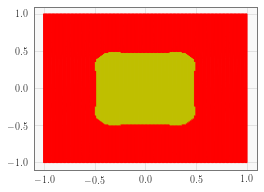

In [5]:
# Switch the model and likelihood into the evaluation mode
model.eval()
likelihood.eval()

# Start the plot, 4x3in
f, ax = plt.subplots(1, 1, figsize=(4, 3))

n = 150
test_x = torch.zeros(n ** 2, 2)
test_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
test_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
# Cuda variable of test data
test_x = test_x.cuda()

with torch.no_grad():
    predictions = likelihood(model(test_x))

# prob<0.5 --> label -1 // prob>0.5 --> label 1
pred_labels = predictions.mean.ge(0.5).float().mul(2).sub(1).cpu()
# Colors = yellow for 1, red for -1
color = []
for i in range(len(pred_labels)):
    if pred_labels[i] == 1:
        color.append('y')
    else:
        color.append('r')
        
# Plot data a scatter plot
ax.scatter(test_x[:, 0].cpu(), test_x[:, 1].cpu(), color=color, s=1)